In [1]:
import akshare as ak
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

def set_chinese_font():
    """
    自动查找并设置支持中文的字体，避免Glyph missing警告
    """
    # 常见的中文字体名称列表
    chinese_fonts = [
        'SimHei', 'SimSun', 'Microsoft YaHei', 'STHeiti', 
        'Songti SC', 'PingFang SC', 'Noto Sans CJK SC',
        'AR PL UKai CN', 'Noto Sans Kaithi', 'WenQuanYi Micro Hei'
    ]
    
    available_fonts = set([f.name for f in fm.fontManager.ttflist])
    
    # 查找第一个可用的中文字体
    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            break
    
    # 如果找不到预定义的字体，则使用系统中的任意字体
    if not selected_font:
        # 查找任何包含中文字符的字体
        for font in available_fonts:
            if any(chinese_char in font for chinese_char in ['黑', '宋', '楷', '仿', '苹', '微']):
                selected_font = font
                break
    
    # 设置字体
    if selected_font:
        plt.rcParams['font.sans-serif'] = [selected_font, 'DejaVu Sans']
        print(f"已设置中文字体: {selected_font}")
    else:
        # 备用方案：使用默认字体但确保能显示基本中文
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']
        print("未找到合适的中文字体，使用默认字体")
        
    # 确保负号正常显示
    plt.rcParams['axes.unicode_minus'] = False
    
    return selected_font
set_chinese_font()
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

已设置中文字体: SimHei


In [2]:
def merge_fund_data_by_date(*dataframes):
    merged_df = dataframes[0][['date', 'price']].copy()
    merged_df.columns = ['date', 'price_0']
    for i, df in enumerate(dataframes[1:], 1):
        temp_df = df[['date', 'price']].copy()
        temp_df.columns = ['date', f'price_{i}']
        merged_df = merged_df.merge(temp_df, on='date', how='inner')
    price_columns = [col for col in merged_df.columns if col.startswith('price_')]
    merged_df['price'] = merged_df[price_columns].sum(axis=1)/len(price_columns)
    return merged_df[['date', 'price']]

def quit_zero(stock):
    stock_zero_mask = stock['price'] == 0
    zero_indices = stock[stock_zero_mask].index
    for idx in zero_indices:
        # 查找前一个非零值
        prev_idx = idx - 1
        while prev_idx >= 0 and stock.loc[prev_idx, 'price'] == 0:
            prev_idx -= 1
        
        # 查找后一个非零值
        next_idx = idx + 1
        while next_idx < len(stock) and stock.loc[next_idx, 'price'] == 0:
            next_idx += 1
        
        # 计算前后非零值的平均值
        prev_value = stock.loc[prev_idx, 'price'] if prev_idx >= 0 else 0
        next_value = stock.loc[next_idx, 'price'] if next_idx < len(stock) else prev_value
        
        # 如果前值为0但后值不为0，则使用后值
        if prev_value == 0 and next_value != 0:
            stock.loc[idx, 'price'] = next_value
        # 如果后值为0但前值不为0，则使用前值
        elif next_value == 0 and prev_value != 0:
            stock.loc[idx, 'price'] = prev_value
        # 如果前后值都不为0，则取平均值
        elif prev_value != 0 and next_value != 0:
            stock.loc[idx, 'price'] = (prev_value + next_value) / 2
        # 如果都为0，则保持原值（这种情况很少见）

# 黄金 000218
# 短融 000128, 008448
# 长债  003376
# 30长债 010309
# 美债 004998
# 红利 161907, 510880, 009051
# 红利低波 005561, 512890, 021482
# 标普 161125
# 纳斯达克 160213
# 创业板 110026
# 上证50 001051
# 沪深300 460300
def get_data():
    d1 = ak.fund_open_fund_info_em(symbol="000218", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    cash = ak.fund_open_fund_info_em(symbol="000128", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'}) #短融现金储备不能改
    d2 = ak.fund_open_fund_info_em(symbol="010309", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    #股票
    d3 = ak.fund_open_fund_info_em(symbol="510880", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d4 = ak.fund_open_fund_info_em(symbol="512890", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    stock = merge_fund_data_by_date(d3, d4)
    # d3 = ak.fund_open_fund_info_em(symbol="110026", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # d4 = ak.fund_open_fund_info_em(symbol="001051", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # d5 = ak.fund_open_fund_info_em(symbol="460300", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # stock = merge_fund_data_by_date(d3, d4, d5)
    # d6 = ak.fund_open_fund_info_em(symbol="512890", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # stock = merge_fund_data_by_date(d3, d4, d5, d6)
    quit_zero(stock)
    dataframes = [d1, cash, d2, stock]
    merged_data = reduce(lambda left, right: left.merge(right, on='date', how='inner', suffixes=('', '_right')), dataframes)
    merged_data.columns = ['date', '黄金', '短融', '长债', '股票']
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data
# 比特币逻辑
# def get_data():
#     d1 = ak.fund_open_fund_info_em(symbol="000218", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
#     cash = ak.fund_open_fund_info_em(symbol="000128", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'}) #短融现金储备不能改
#     d2 = ak.fund_open_fund_info_em(symbol="003376", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
#     d7 = pd.read_csv('./btc_daily_nav_2016_to_now.csv')
#     d7['date'] = pd.to_datetime(d7['date']).dt.date
#     d1['date'] = pd.to_datetime(d1['date']).dt.date
#     cash['date'] = pd.to_datetime(cash['date']).dt.date
#     d2['date'] = pd.to_datetime(d2['date']).dt.date
#     dataframes = [d1, cash, d2, d7]
#     merged_data = reduce(lambda left, right: left.merge(right, on='date', how='inner', suffixes=('', '_right')), dataframes)
#     merged_data.columns = ['date', '黄金', '短融', '长债', '股票']
#     # 如果需要，可以将日期列转换回datetime类型
#     merged_data['date'] = pd.to_datetime(merged_data['date'])
#     return merged_data
merged_data = get_data()
start_year = 2018
start_month = 4
first_date = merged_data['date'].iloc[0]
if first_date.month == 12:
    start_year = first_date.year + 1
    start_month = 1
else:
    start_year = first_date.year
    start_month = first_date.month + 1
end_year = datetime.now().year
end_month = datetime.now().month
print(merged_data)
# merged_data[['黄金', '短融', '长债', '股票']].plot()

           date      黄金      短融      长债       股票
0    2020-12-21  1.4721  1.3823  1.0000  1.86395
1    2020-12-25  1.4578  1.3837  0.9998  1.82885
2    2020-12-30  1.4513  1.3851  1.0006  1.81575
3    2020-12-31  1.4504  1.3855  1.0007  1.82245
4    2021-01-04  1.4795  1.3856  1.0007  1.81730
...         ...     ...     ...     ...      ...
1186 2025-11-17  3.3661  1.5248  1.2139  2.78515
1187 2025-11-18  3.3152  1.5248  1.2137  2.76095
1188 2025-11-19  3.3796  1.5248  1.2116  2.76890
1189 2025-11-20  3.3618  1.5248  1.2108  2.77370
1190 2025-11-21  3.3419  1.5247  1.2096  2.74370

[1191 rows x 5 columns]


In [3]:
def equal_risk(current_price, see_months=3, invest_amount=10000):
    merged_data = get_data()
    recent_data = merged_data.tail(see_months*20).copy()
    etf_columns = ['黄金', '长债', '股票']
    for col in etf_columns:
        recent_data.loc[:, f'{col}_pct'] = recent_data.loc[:, col].pct_change(fill_method=None) * 100

    pct_columns = ['黄金_pct', '长债_pct', '股票_pct']
    etf_data = recent_data.loc[:, pct_columns]
    daily_returns = etf_data.dropna()
    volatility = daily_returns.std() * np.sqrt(252)
    print(f"各类资产{see_months}个月年化波动率：")
    print(volatility.round(4), "\n")
    current_weights = current_price / current_price.sum()
    current_weights = pd.Series(current_weights, index=pct_columns)

    # 风险贡献 = 仓位权重 × 资产波动率
    risk_contribution = current_weights * volatility
    total_risk = risk_contribution.sum()

    # 风险贡献占比（当前风险比例）
    risk_ratio = (risk_contribution / total_risk).round(4) * 100
    print("当前仓位的风险贡献占比：")
    print(risk_ratio, "\n")

    target_risk_ratio = 1/3  # 33.33%

    # 加仓系数 = 目标风险占比 / 当前风险占比（风险越高，系数越小，加仓越少）
    add_coefficient = target_risk_ratio / (risk_ratio / 100)
    print("定投加仓系数：")
    print(add_coefficient.round(4), "\n")

    # 分配加仓金额（假设当月定投1万元）
    add_weights = add_coefficient / add_coefficient.sum()  # 加仓比例
    add_amount = (add_weights * invest_amount).round(0)

    print(f"{invest_amount}元定投的加仓金额分配：")
    result = pd.DataFrame({
        '当前仓位权重': current_weights * 100,
        '当前风险占比(%)': risk_ratio,
        '加仓系数': add_coefficient.round(4),
        '定投金额(元)': add_amount
    })
    print(result)

In [4]:
def analyze_etf_monthly_data(year, month):
    """
    分析指定年月的ETF数据并计算风险比例和相关系数
    
    Parameters:
    year (int): 年份
    month (int): 月份
    
    Returns:
    tuple: (risk_contribution, correlation_matrix)
    """
    merged_data = get_data()
    
    mask = (merged_data['date'].dt.year == year) & (merged_data['date'].dt.month == month)
    monthly_data = merged_data.loc[mask].copy() 
    
    if monthly_data.empty:
        print(f"警告: {year}年{month}月没有找到数据")
        return None, None
    
    etf_columns = ['黄金', '短融', '长债', '股票']
    for col in etf_columns:
        monthly_data.loc[:, f'{col}_pct'] = monthly_data.loc[:, col].pct_change(fill_method=None) * 100
    
    pct_columns = ['黄金_pct', '短融_pct', '长债_pct', '股票_pct']
    etf_data = monthly_data.loc[:, pct_columns]
    etf_data = etf_data.dropna()
    
    if etf_data.empty:
        print(f"警告: {year}年{month}月数据不足，无法计算统计指标")
        return None, None
    
    volatility = etf_data.std() * np.sqrt(252)  # 年化波动率
    total_volatility = volatility.sum()
    risk_contribution = volatility / total_volatility * 100
    
    return risk_contribution, etf_data.corr()

def get_etf_analysis_period(start_year, start_month, end_year, end_month):
    """
    获取指定时间段内每月的ETF风险比例和相关系数矩阵
    
    Parameters:
    start_year (int): 开始年份
    start_month (int): 开始月份
    end_year (int): 结束年份
    end_month (int): 结束月份
    
    Returns:
    dict: 包含每月风险比例和相关系数矩阵的字典
    """
    results = {}
    current_year = start_year
    current_month = start_month
    
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        try:
            risk_ratio, corr_matrix = analyze_etf_monthly_data(current_year, current_month)
            if risk_ratio is not None and corr_matrix is not None:
                results[f"{current_year}-{current_month:02d}"] = {
                    'risk_ratio': risk_ratio,
                    'corr_matrix': corr_matrix
                }
            else:
                print(f"{current_year}年{current_month:02d}月 数据不足或不存在")
        except Exception as e:
            print(f"处理 {current_year}年{current_month:02d}月 数据时出错: {e}")
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    return results

def print_summary_statistics(results):
    """
    打印汇总统计信息
    """
    if not results:
        print("没有数据可供统计")
        return
    
    dates = sorted(list(results.keys()))
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    periods = {
        "近1个月": 1,
        "近3个月": 3,
        "近半年": 6,
        "近1年": 12,
        "近3年": 36,
        "从最早到目前为止": len(dates)
    }
    
    for period_name, months in periods.items():
        if months >= len(dates):
            period_dates = dates 
        else:
            start_index = max(0, len(dates) - months)
            period_dates = dates[start_index:]
        
        if not period_dates:
            print(f"\n{period_name}: 没有数据")
            continue
            
        avg_risk_data = {}
        for etf in etf_names:
            avg_risk_data[etf] = sum([results[date]['risk_ratio'][etf] for date in period_dates]) / len(period_dates)
        
        print(f"\n{period_name} ({period_dates[0]} 到 {period_dates[-1]}):")
        print("  平均风险比例:")
        for etf, ratio in avg_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
        if months <= 6:
            continue
        median_risk_data = {}
        for etf in etf_names:
            risk_values = [results[date]['risk_ratio'][etf] for date in period_dates]
            risk_values.sort()
            n = len(risk_values)
            if n % 2 == 0:
                median_risk_data[etf] = (risk_values[n//2 - 1] + risk_values[n//2]) / 2
            else:
                median_risk_data[etf] = risk_values[n//2]
        
        print("  中位数风险比例:")
        for etf, ratio in median_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
def visualize_risk_ratios(results):
    """
    可视化风险比例变化趋势
    """
    if not results:
        print("没有数据可供可视化")
        return
    
    # 准备数据
    dates = list(results.keys())
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    # 创建DataFrame存储风险比例数据
    risk_data = {}
    for etf in etf_names:
        risk_data[etf] = [results[date]['risk_ratio'][etf] for date in dates]
    
    risk_df = pd.DataFrame(risk_data, index=dates)
    
    # 绘制风险比例变化图
    plt.figure(figsize=(24, 8))
    for etf in etf_names:
        plt.plot(risk_df.index, risk_df[etf], marker='o', label=etf, linewidth=2)
    
    plt.title('各ETF风险比例月度变化趋势', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('风险比例', fontsize=12)
    plt.legend()
    plt.xticks(rotation=65)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def calculate_portfolio_drawdown_and_recovery(merged_data, weights):
    """
    计算给定权重的投资组合的最大回撤和回撤修复时间
    
    Parameters:
    merged_data (DataFrame): 包含各资产净值数据的DataFrame
    weights (dict): 各资产的权重配置
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    
    # 计算回撤
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = portfolio_df['drawdown'].idxmin()
    max_drawdown = portfolio_df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = portfolio_df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = portfolio_df.loc[max_drawdown_idx, 'peak']
    # peak_idx = portfolio_df[portfolio_df['date'] <= max_drawdown_date][portfolio_df['value'] == peak_value].index[-1]
    mask = (portfolio_df['date'] <= max_drawdown_date) & (portfolio_df['value'] == peak_value)
    peak_idx = portfolio_df[mask].index[-1]
    peak_date = portfolio_df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(portfolio_df)):
        if portfolio_df.loc[idx, 'value'] >= peak_value:
            recovery_idx = idx
            recovery_date = portfolio_df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months

def calculate_max_drawdown_and_recovery(data, asset_column):
    """
    计算最大回撤和回撤修复时间
    
    Parameters:
    data (DataFrame): 包含日期和资产净值的数据
    asset_column (str): 资产列名
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 确保数据按日期排序
    df = data[['date', asset_column]].copy()
    df = df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    df['peak'] = df[asset_column].expanding(min_periods=1).max()
    
    # 计算回撤
    df['drawdown'] = (df[asset_column] - df['peak']) / df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = df['drawdown'].idxmin()
    max_drawdown = df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = df.loc[max_drawdown_idx, 'peak']
    mask = (df['date'] <= max_drawdown_date) & (df[asset_column] == peak_value)
    peak_idx = df[mask].index[-1]
    peak_date = df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(df)):
        if df.loc[idx, asset_column] >= peak_value:
            recovery_idx = idx
            recovery_date = df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months


# 绘制组合回撤曲线图
def plot_portfolio_drawdown(merged_data, weights):
    """
    绘制投资组合的回撤曲线
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值和回撤
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 绘制图形
    plt.figure(figsize=(14, 10))
    
    # 子图1: 组合净值走势
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_df['date'], portfolio_df['value'], color='purple', linewidth=2, label='组合净值')
    plt.plot(portfolio_df['date'], portfolio_df['peak'], color='green', linestyle='--', linewidth=1, label='历史峰值')
    plt.title('投资组合净值走势', fontsize=14)
    plt.ylabel('净值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    max_dd_idx = portfolio_df['drawdown'].idxmin()
    max_dd_value = portfolio_df.loc[max_dd_idx, 'drawdown']
    max_dd_date = portfolio_df.loc[max_dd_idx, 'date']
    max_dd_nav = portfolio_df.loc[max_dd_idx, 'value']
    peak_value = portfolio_df.loc[max_dd_idx, 'peak']
    
    plt.scatter(max_dd_date, max_dd_nav, color='red', s=80, zorder=5)
    plt.annotate(f'最大回撤点\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_nav), 
                xytext=(20, 20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 子图2: 回撤曲线
    plt.subplot(2, 1, 2)
    plt.plot(portfolio_df['date'], portfolio_df['drawdown'], color='red', linewidth=2)
    plt.fill_between(portfolio_df['date'], portfolio_df['drawdown'], 0, color='red', alpha=0.3)
    plt.title('投资组合回撤曲线', fontsize=14)
    plt.ylabel('回撤 (%)')
    plt.xlabel('日期')
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    plt.scatter(max_dd_date, max_dd_value, color='darkred', s=80, zorder=5)
    plt.annotate(f'最大回撤\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_value), 
                xytext=(20, -20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    return portfolio_df


开始分析2021年1月至2025年11月的ETF数据...

近1个月 (2025-11 到 2025-11):
  平均风险比例:
    黄金_pct: 64.2234
    短融_pct: 0.4807
    长债_pct: 7.0685
    股票_pct: 28.2274

近3个月 (2025-09 到 2025-11):
  平均风险比例:
    黄金_pct: 61.0268
    短融_pct: 0.6869
    长债_pct: 11.7113
    股票_pct: 26.5750

近半年 (2025-06 到 2025-11):
  平均风险比例:
    黄金_pct: 52.5324
    短融_pct: 0.7269
    长债_pct: 14.4501
    股票_pct: 32.2906

近1年 (2024-12 到 2025-11):
  平均风险比例:
    黄金_pct: 49.0874
    短融_pct: 0.9255
    长债_pct: 16.5041
    股票_pct: 33.4829
  中位数风险比例:
    黄金_pct: 48.1144
    短融_pct: 0.8647
    长债_pct: 16.6514
    股票_pct: 32.8140

近3年 (2022-12 到 2025-11):
  平均风险比例:
    黄金_pct: 47.0848
    短融_pct: 1.0064
    长债_pct: 8.1705
    股票_pct: 43.7384
  中位数风险比例:
    黄金_pct: 48.9459
    短融_pct: 0.8665
    长债_pct: 4.8634
    股票_pct: 40.5922

从最早到目前为止 (2021-01 到 2025-11):
  平均风险比例:
    黄金_pct: 44.5141
    短融_pct: 0.8614
    长债_pct: 6.3539
    股票_pct: 48.2706
  中位数风险比例:
    黄金_pct: 45.9351
    短融_pct: 0.6577
    长债_pct: 4.0035
    股票_pct: 47.5262


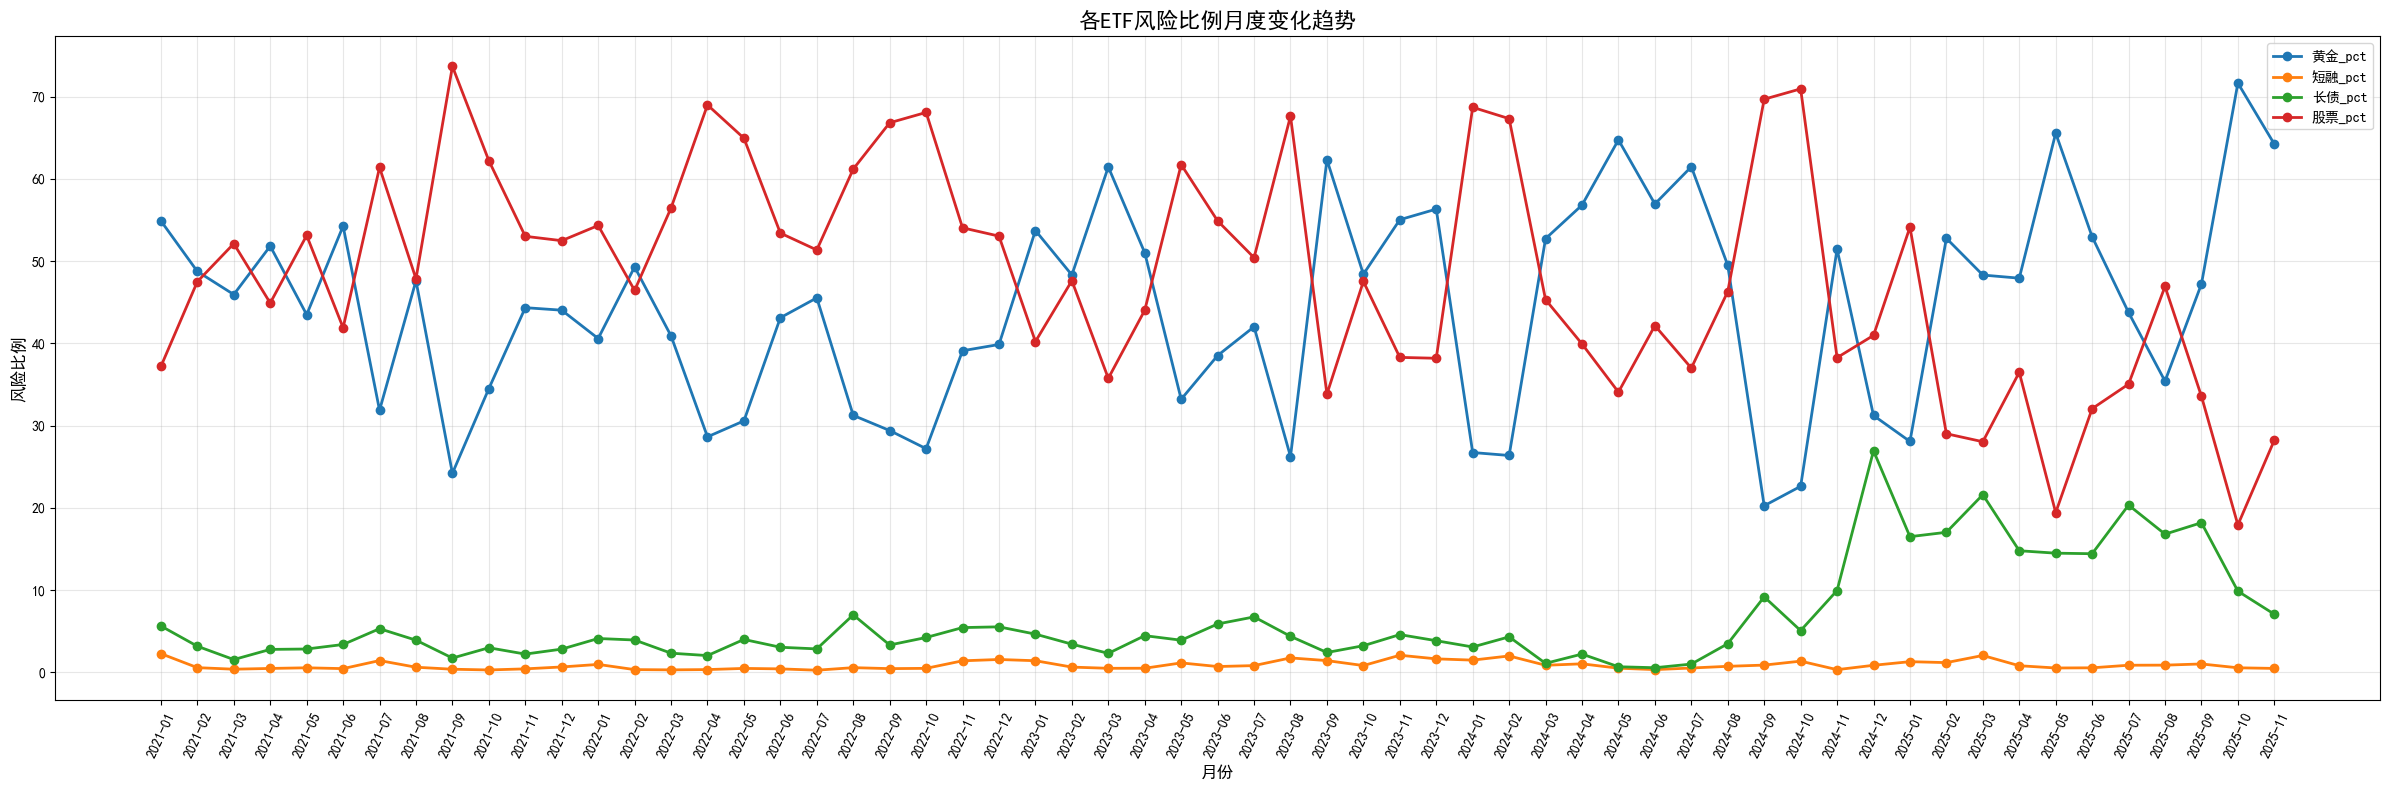

指定权重组合的最大回撤及修复时间分析
组合权重配置:
  短融: 25.0%
  长债: 25.0%
  黄金: 25.0%
  股票: 25.0%

分析结果:
  最大回撤: -4.54%
  回撤开始日期(峰值): 2021-09-13
  最大回撤日期: 2021-11-05
  回撤修复日期: 2022-04-01
  修复时间: 7 个月


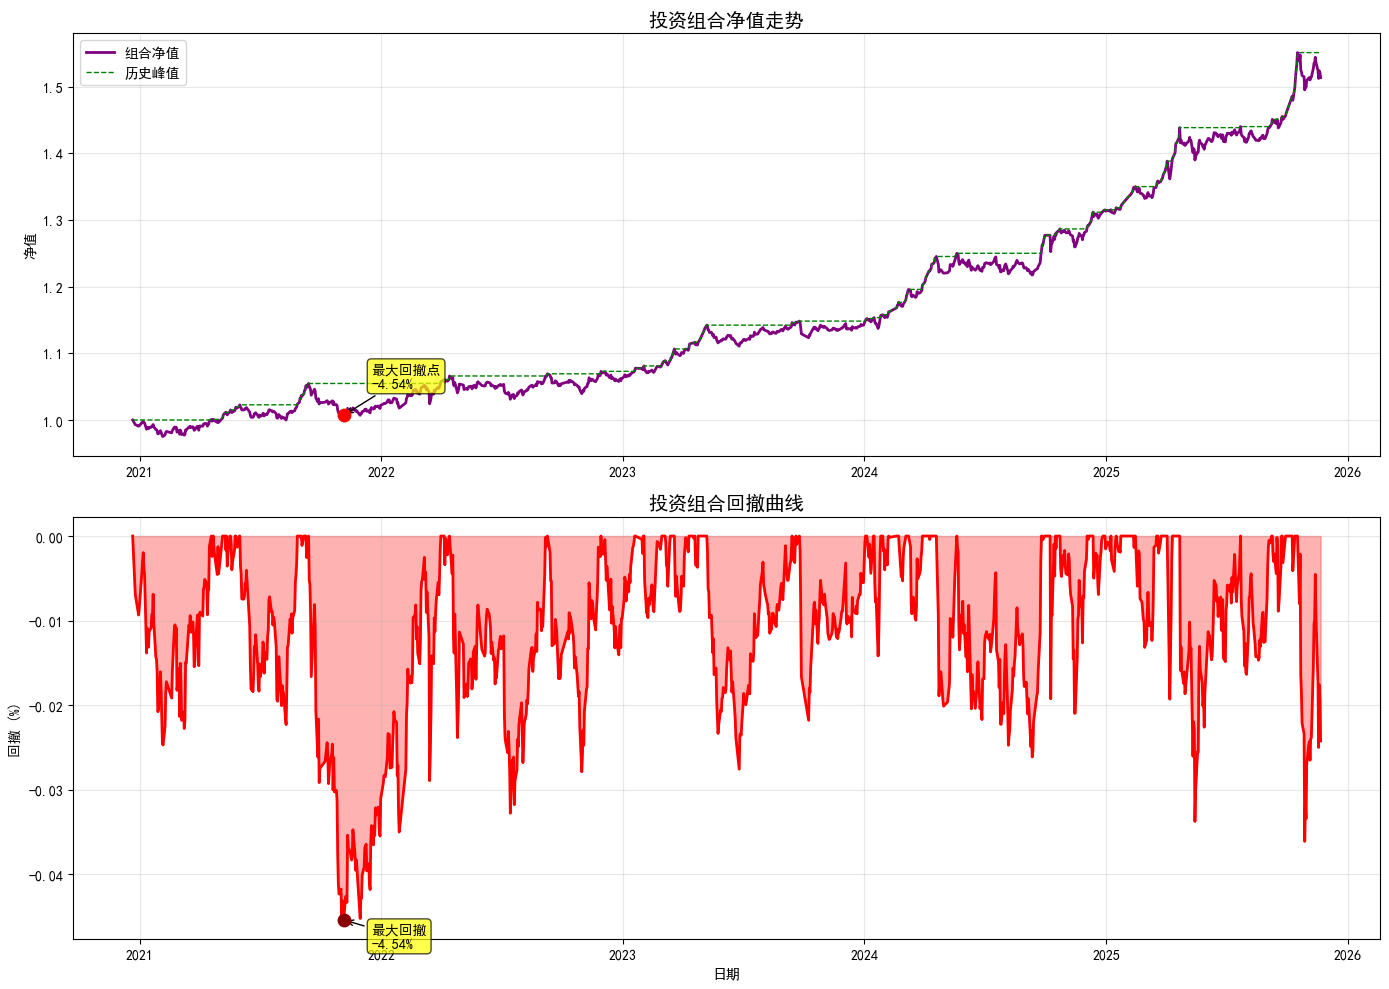


组合与各单项资产最大回撤对比
资产         最大回撤       修复时间      
------------------------------
黄金            -11.40% 14个月      
短融             -0.29% 2个月       
长债             -5.14% 未修复       
股票            -15.67% 19个月      
组合             -4.54% 7         

风险分散效果:
  各资产平均最大回撤: 8.12%
  组合最大回撤: 4.54%
  风险降低幅度: 44.12%


In [5]:
print(f"开始分析{start_year}年{start_month}月至{end_year}年{end_month}月的ETF数据...")
results = get_etf_analysis_period(start_year, start_month, end_year, end_month)
print_summary_statistics(results)
visualize_risk_ratios(results)
# 定义资产权重
portfolio_weights = {
    '短融': 0.25,
    '长债': 0.25,
    '黄金': 0.25,
    '股票': 0.25,
}

# 计算组合最大回撤和修复时间
try:
    max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(
        merged_data, portfolio_weights
    )
    
    print("="*60)
    print("指定权重组合的最大回撤及修复时间分析")
    print("="*60)
    print("组合权重配置:")
    for asset, weight in portfolio_weights.items():
        print(f"  {asset}: {weight*100:.1f}%")
    print()
    print("分析结果:")
    print(f"  最大回撤: {max_dd*100:.2f}%")
    print(f"  回撤开始日期(峰值): {peak_date.strftime('%Y-%m-%d')}")
    print(f"  最大回撤日期: {dd_date.strftime('%Y-%m-%d')}")
    
    if recovery_date:
        print(f"  回撤修复日期: {recovery_date.strftime('%Y-%m-%d')}")
        print(f"  修复时间: {recovery_months} 个月")
    else:
        print("  回撤修复日期: 尚未修复")
        # 计算至今的修复时间
        last_date = merged_data['date'].max()
        months_since_peak = (last_date.year - peak_date.year) * 12 + (last_date.month - peak_date.month)
        print(f"  至今修复时间: {months_since_peak} 个月 (尚未完全修复)")

except Exception as e:
    print(f"计算组合回撤时出现错误: {e}")
# 绘制组合回撤曲线
portfolio_df = plot_portfolio_drawdown(merged_data, portfolio_weights)

# 与各单项资产回撤对比
print("\n" + "="*60)
print("组合与各单项资产最大回撤对比")
print("="*60)

# 计算并显示各单项资产的回撤
individual_drawdowns = {}
assets = ['黄金', '短融', '长债', '股票']

print(f"{'资产':<10} {'最大回撤':<10} {'修复时间':<10}")
print("-" * 30)
for asset in assets:
    max_dd, _, _, _, recovery_months = calculate_max_drawdown_and_recovery(merged_data, asset)
    individual_drawdowns[asset] = abs(max_dd)
    recovery_text = f"{recovery_months}个月" if recovery_months else "未修复"
    print(f"{asset:<10} {max_dd*100:>9.2f}% {recovery_text:<10}")

# 计算组合回撤
max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(merged_data, portfolio_weights)
portfolio_max_dd = max_dd
print(f"{'组合':<10} {portfolio_max_dd*100:>9.2f}% {recovery_months if recovery_months else '未修复':<10}")

# 计算风险降低效果
avg_individual_drawdown = np.mean(list(individual_drawdowns.values()))
risk_reduction = (avg_individual_drawdown - abs(portfolio_max_dd)) / avg_individual_drawdown * 100

print(f"\n风险分散效果:")
print(f"  各资产平均最大回撤: {avg_individual_drawdown*100:.2f}%")
print(f"  组合最大回撤: {abs(portfolio_max_dd)*100:.2f}%")
print(f"  风险降低幅度: {risk_reduction:.2f}%")

# 融合回测

In [6]:
import akshare as ak
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional

In [7]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List

def _annualize_vol(returns: pd.Series, periods_per_year: int = 12) -> float:
    """计算年化波动率"""
    return returns.std(ddof=1) * np.sqrt(periods_per_year)

def inverse_vol_weights(vols: np.ndarray) -> np.ndarray:
    """根据波动率计算逆波动率权重"""
    MIN_VOL = 0.001
    vols_safe = np.maximum(vols, MIN_VOL)
    inv = 1.0 / vols_safe
    w = inv / np.sum(inv)
    return w

def compute_monthly_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """将日度数据转换为月度数据（取月末价格）"""
    df = prices.copy()
    if 'date' in df.columns:
        df = df.set_index(pd.to_datetime(df['date'])).drop(columns=['date'])
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError('prices must have a DatetimeIndex or a date column')
    monthly = df.resample('ME').last()
    return monthly

def calculate_portfolio_contribution_vol(
    returns: pd.DataFrame,
    holdings: Dict[str, float],
    prices: pd.Series,
    assets: list
) -> np.ndarray:
    """计算组合中各资产的风险贡献（简化版）"""
    total_value = sum(holdings[a] * prices[a] for a in assets)
    if total_value <= 0:
        return np.array([1/len(assets)] * len(assets))
    
    current_weights = np.array([holdings[a] * prices[a] / total_value for a in assets])
    vols = np.array([_annualize_vol(returns[a].dropna()) for a in assets])
    risk_contributions = current_weights * vols
    
    return risk_contributions

def rebalance_portfolio(
    holdings: Dict[str, float],
    current_prices: pd.Series,
    target_weights: Dict[str, float],
    assets: List[str],
    transaction_cost_rate: float = 0.001  # 0.1% 交易成本
) -> Tuple[Dict[str, float], List[Dict], float]:
    """
    执行组合再平衡
    
    参数:
    - holdings: 当前持仓份额
    - current_prices: 当前价格
    - target_weights: 目标权重
    - assets: 资产列表
    - transaction_cost_rate: 交易成本率
    
    返回:
    - 调整后的持仓
    - 交易记录列表
    - 总交易成本
    """
    # 计算当前市值和权重
    current_values = {a: holdings[a] * current_prices[a] for a in assets}
    total_value = sum(current_values.values())
    current_weights = {a: current_values[a] / total_value for a in assets}
    
    # 计算目标市值
    target_values = {a: total_value * target_weights[a] for a in assets}
    
    # 计算需要调整的金额
    adjustments = {a: target_values[a] - current_values[a] for a in assets}
    
    # 分离买入和卖出
    to_sell = {a: -adj for a, adj in adjustments.items() if adj < -0.01}  # 卖出（金额为正）
    to_buy = {a: adj for a, adj in adjustments.items() if adj > 0.01}    # 买入（金额为正）
    
    transactions = []
    total_transaction_cost = 0.0
    new_holdings = holdings.copy()
    
    # 先卖出超配资产
    cash_from_selling = 0.0
    for asset, sell_value in to_sell.items():
        sell_shares = sell_value / current_prices[asset]
        transaction_cost = sell_value * transaction_cost_rate
        cash_from_selling += sell_value - transaction_cost
        
        new_holdings[asset] -= sell_shares
        total_transaction_cost += transaction_cost
        
        transactions.append({
            'action': '卖出',
            'asset': asset,
            'amount': sell_value,
            'shares': sell_shares,
            'price': current_prices[asset],
            'cost': transaction_cost
        })
    
    # 再买入低配资产
    if len(to_buy) > 0 and cash_from_selling > 0:
        # 按比例分配可用资金
        total_to_buy = sum(to_buy.values())
        available_cash = cash_from_selling  # 卖出所得现金
        
        for asset, buy_value in to_buy.items():
            # 按原始需求比例分配可用资金
            actual_buy_value = min(buy_value, available_cash * (buy_value / total_to_buy))
            transaction_cost = actual_buy_value * transaction_cost_rate
            net_buy_value = actual_buy_value - transaction_cost
            buy_shares = net_buy_value / current_prices[asset]
            
            new_holdings[asset] += buy_shares
            total_transaction_cost += transaction_cost
            
            transactions.append({
                'action': '买入',
                'asset': asset,
                'amount': actual_buy_value,
                'shares': buy_shares,
                'price': current_prices[asset],
                'cost': transaction_cost
            })
    
    return new_holdings, transactions, total_transaction_cost

def backtest_permanent_portfolio_v2(
    start_year: int,
    start_month: int,
    price: float,
    M: int,
    cash_col: str = '短融',
    longbond_col: str = '长债',
    gold_col: str = '黄金',
    equity_col: str = '股票',
    alpha: float = 0.0,  # 默认纯永久组合
    vol_lookback: int = 6,
    initial_capital: float = 0.0,
    use_portfolio_vol: bool = True,
    rebalance_threshold: float = 0.1,  # 偏离5%触发调仓
    transaction_cost_rate: float = 0.001,  # 0.1%交易成本
) -> Dict:
    """
    改进的永久组合回测（完整调仓版）
    
    核心逻辑：
    1. 每次定投后，先用新钱尽量纠偏
    2. 检查偏离度，超过阈值则卖出超配、买入低配
    3. 考虑交易成本
    """
    
    df = get_data()
    prices_monthly = compute_monthly_prices(df)
    
    start_ts = pd.Timestamp(start_year, start_month, 1)
    if start_ts not in prices_monthly.index:
        valid_dates = prices_monthly.index[prices_monthly.index >= start_ts]
        if len(valid_dates) == 0:
            raise ValueError(f"没有足够的数据从 {start_year}-{start_month} 开始回测")
        start_ts = valid_dates[0]
    
    start_idx = prices_monthly.index.get_loc(start_ts)
    
    if start_idx + M > len(prices_monthly):
        raise ValueError(f"数据不足：需要 {M} 个月，但只有 {len(prices_monthly) - start_idx} 个月可用")
    
    assets = [cash_col, longbond_col, gold_col, equity_col]
    risk_assets = [longbond_col, gold_col, equity_col]
    holdings = {a: 0.0 for a in assets}
    total_cost = 0.0
    total_transaction_costs = 0.0
    
    monthly_records = []
    
    print(f"\n{'='*80}")
    print(f"永久组合回测（完整版）：{start_year}年{start_month}月 开始，定投 {M} 个月")
    print(f"参数：alpha={alpha}, 调仓阈值={rebalance_threshold:.1%}, 交易成本={transaction_cost_rate:.2%}")
    print(f"{'='*80}\n")
    
    # 初始建仓
    if initial_capital > 0:
        date_0 = prices_monthly.index[start_idx]
        print(f"📍 第 0 月初始建仓 ({date_0.date()})")
        print(f"初始资金: {initial_capital:.2f}元\n")
        
        target_weights = {a: 0.25 for a in assets}
        
        for asset in assets:
            amount = initial_capital * target_weights[asset]
            price_0 = prices_monthly.loc[date_0, asset]
            shares = amount / price_0
            holdings[asset] += shares
            total_cost += amount
            print(f"  {asset}: 投入 {amount:.2f}元, 价格 {price_0:.4f}, 份额 {shares:.4f}")
        
        print()
    
    # 月度定投循环
    for i in range(M):
        month_idx = start_idx + i
        date = prices_monthly.index[month_idx]
        current_prices = prices_monthly.loc[date]
        
        print(f"{'='*80}")
        print(f"📅 第 {i+1} 月定投 ({date.date()})")
        print(f"{'='*80}")
        
        # === 步骤1：计算目标权重 ===
        lookback_start = max(0, month_idx - vol_lookback)
        window_returns = prices_monthly.pct_change().iloc[lookback_start:month_idx+1].dropna(how='all')
        
        if alpha == 0:
            # 纯永久组合：四资产各25%
            target_weights = {a: 0.25 for a in assets}
        elif alpha == 1:
            # 纯风险平价
            if use_portfolio_vol and i > 0 and window_returns.shape[0] >= 2:
                risk_contribs = calculate_portfolio_contribution_vol(
                    window_returns, holdings, current_prices, risk_assets
                )
                rp3 = inverse_vol_weights(risk_contribs)
            else:
                if window_returns.shape[0] < 2:
                    vols = np.array([
                        _annualize_vol(prices_monthly[longbond_col].pct_change().dropna()),
                        _annualize_vol(prices_monthly[gold_col].pct_change().dropna()),
                        _annualize_vol(prices_monthly[equity_col].pct_change().dropna()),
                    ])
                else:
                    vols = np.array([
                        _annualize_vol(window_returns[longbond_col].dropna()),
                        _annualize_vol(window_returns[gold_col].dropna()),
                        _annualize_vol(window_returns[equity_col].dropna()),
                    ])
                rp3 = inverse_vol_weights(vols)
            
            target_weights = {
                cash_col: 0.25,
                longbond_col: float(rp3[0] * 0.75),
                gold_col: float(rp3[1] * 0.75),
                equity_col: float(rp3[2] * 0.75)
            }
        else:
            # 混合策略
            if use_portfolio_vol and i > 0 and window_returns.shape[0] >= 2:
                risk_contribs = calculate_portfolio_contribution_vol(
                    window_returns, holdings, current_prices, risk_assets
                )
                rp3 = inverse_vol_weights(risk_contribs)
            else:
                if window_returns.shape[0] < 2:
                    vols = np.array([
                        _annualize_vol(prices_monthly[longbond_col].pct_change().dropna()),
                        _annualize_vol(prices_monthly[gold_col].pct_change().dropna()),
                        _annualize_vol(prices_monthly[equity_col].pct_change().dropna()),
                    ])
                else:
                    vols = np.array([
                        _annualize_vol(window_returns[longbond_col].dropna()),
                        _annualize_vol(window_returns[gold_col].dropna()),
                        _annualize_vol(window_returns[equity_col].dropna()),
                    ])
                rp3 = inverse_vol_weights(vols)
            
            # 混合：永久组合(1/4) + 风险平价
            pp4 = np.array([0.25, 0.25, 0.25, 0.25])
            rp4 = np.array([0.25, rp3[0]*0.75, rp3[1]*0.75, rp3[2]*0.75])
            rp4 = rp4 / rp4.sum()
            
            blended = alpha * rp4 + (1 - alpha) * pp4
            target_weights = {
                cash_col: float(blended[0]),
                longbond_col: float(blended[1]),
                gold_col: float(blended[2]),
                equity_col: float(blended[3])
            }
        
        # === 步骤2：计算当前状态 ===
        current_value = sum(holdings[a] * current_prices[a] for a in assets)
        
        if current_value > 0:
            current_weights = {
                a: holdings[a] * current_prices[a] / current_value 
                for a in assets
            }
            print(f"\n📊 定投前状态:")
            print(f"   总市值: {current_value:.2f}元")
            print(f"   当前权重: ", end="")
            for a in assets:
                print(f"{a}={current_weights[a]:.1%} ", end="")
            print()
        else:
            current_weights = {a: 0.25 for a in assets}
        
        print(f"   目标权重: ", end="")
        for a in assets:
            print(f"{a}={target_weights[a]:.1%} ", end="")
        print()
        
        # === 步骤3：智能定投（用新钱纠偏）===
        print(f"\n💰 本月定投 {price:.2f}元")
        
        target_value_after = current_value + price
        target_values = {a: target_value_after * target_weights[a] for a in assets}
        current_values = {a: holdings[a] * current_prices[a] for a in assets}
        gaps = {a: target_values[a] - current_values[a] for a in assets}
        
        # 新钱优先投向缺口大的资产
        to_invest = {a: gap for a, gap in gaps.items() if gap > 0}
        total_gap = sum(to_invest.values())
        
        if total_gap > 0:
            if total_gap <= price:
                # 新钱足够填补所有缺口
                for asset, gap in to_invest.items():
                    shares = gap / current_prices[asset]
                    holdings[asset] += shares
                    print(f"   {asset}: 投入 {gap:.2f}元 (填补缺口)")
                
                # 剩余按目标权重分配
                remaining = price - total_gap
                if remaining > 1:
                    for asset in assets:
                        amount = remaining * target_weights[asset]
                        shares = amount / current_prices[asset]
                        holdings[asset] += shares
                        print(f"   {asset}: 投入 {amount:.2f}元 (剩余分配)")
            else:
                # 新钱不够，按比例投入
                scale = price / total_gap
                for asset, gap in to_invest.items():
                    amount = gap * scale
                    shares = amount / current_prices[asset]
                    holdings[asset] += shares
                    print(f"   {asset}: 投入 {amount:.2f}元 (按比例 {scale:.1%})")
        else:
            # 所有资产都超配，按目标权重投入
            for asset in assets:
                amount = price * target_weights[asset]
                shares = amount / current_prices[asset]
                holdings[asset] += shares
                print(f"   {asset}: 投入 {amount:.2f}元 (按权重)")
        
        total_cost += price
        
        # === 步骤4：检查并执行调仓 ===
        new_value = sum(holdings[a] * current_prices[a] for a in assets)
        new_weights = {a: holdings[a] * current_prices[a] / new_value for a in assets}
        
        deviations = {a: abs(new_weights[a] - target_weights[a]) for a in assets}
        max_deviation = max(deviations.values())
        
        print(f"\n📈 定投后状态:")
        print(f"   总市值: {new_value:.2f}元")
        print(f"   实际权重: ", end="")
        for a in assets:
            print(f"{a}={new_weights[a]:.1%} ", end="")
        print()
        print(f"   最大偏离: {max_deviation:.2%}")
        
        if max_deviation > rebalance_threshold:
            print(f"\n⚖️  触发调仓！偏离超过 {rebalance_threshold:.1%}")
            
            holdings, transactions, txn_cost = rebalance_portfolio(
                holdings, current_prices, target_weights, assets, transaction_cost_rate
            )
            
            total_transaction_costs += txn_cost
            
            for txn in transactions:
                print(f"   {txn['action']} {txn['asset']}: "
                      f"{txn['amount']:.2f}元 ({txn['shares']:.4f}份), "
                      f"成本 {txn['cost']:.2f}元")
            
            print(f"   调仓总成本: {txn_cost:.2f}元")
            
            # 重新计算调仓后的权重
            final_value = sum(holdings[a] * current_prices[a] for a in assets)
            final_weights = {a: holdings[a] * current_prices[a] / final_value for a in assets}
            
            print(f"   调仓后权重: ", end="")
            for a in assets:
                print(f"{a}={final_weights[a]:.1%} ", end="")
            print()
        else:
            final_value = new_value
            final_weights = new_weights
        
        # === 计算收益 ===
        total_profit = final_value - total_cost - total_transaction_costs
        profit_rate = (total_profit / total_cost * 100) if total_cost > 0 else 0
        
        print(f"\n💼 本月总结:")
        print(f"   累计投入: {total_cost:.2f}元")
        print(f"   累计成本: {total_transaction_costs:.2f}元")
        print(f"   当前市值: {final_value:.2f}元")
        print(f"   净收益: {total_profit:.2f}元 ({profit_rate:+.2f}%)")
        print()
        
        monthly_records.append({
            'month': i + 1,
            'date': date,
            'total_cost': total_cost,
            'total_value': final_value,
            'profit': total_profit,
            'profit_rate': profit_rate,
            'weights': final_weights.copy(),
            'transaction_costs': total_transaction_costs
        })
    
    # === 最终总结 ===
    final_record = monthly_records[-1]
    years = M / 12
    annualized_return = ((final_record['total_value'] / final_record['total_cost']) ** (1/years) - 1) * 100
    
    # 计算最大回撤
    nav_series = [r['total_value'] / r['total_cost'] for r in monthly_records]
    peak = nav_series[0]
    max_drawdown = 0
    for nav in nav_series:
        if nav > peak:
            peak = nav
        drawdown = (nav - peak) / peak
        if drawdown < max_drawdown:
            max_drawdown = drawdown
    
    print("=" * 80)
    print("📊 回测总结")
    print("=" * 80)
    print(f"定投时长: {M}个月 ({years:.2f}年)")
    print(f"总投入: {final_record['total_cost']:.2f}元")
    print(f"交易成本: {total_transaction_costs:.2f}元 ({total_transaction_costs/final_record['total_cost']*100:.2f}%)")
    print(f"最终市值: {final_record['total_value']:.2f}元")
    print(f"净收益: {final_record['profit']:.2f}元")
    print(f"累计收益率: {final_record['profit_rate']:.2f}%")
    print(f"年化收益率: {annualized_return:.2f}%")
    print(f"最大回撤: {max_drawdown*100:.2f}%")
    print(f"\n最终持仓:")
    for asset in assets:
        value = holdings[asset] * prices_monthly.loc[monthly_records[-1]['date'], asset]
        weight = value / final_record['total_value']
        print(f"  {asset}: {holdings[asset]:.4f}份, 市值 {value:.2f}元 ({weight:.2%})")
    
    return {
        'annualized_return': annualized_return,
        'total_return': final_record['profit_rate'],
        'max_drawdown': max_drawdown * 100,
        'total_cost': final_record['total_cost'],
        'final_value': final_record['total_value'],
        'transaction_costs': total_transaction_costs,
        'monthly_records': monthly_records,
        'holdings': holdings
    }

In [9]:
if __name__ == "__main__":
    result = backtest_permanent_portfolio_v2(
        start_year=2021,
        start_month=2,
        price=10000,
        M=4*12+10,
        alpha=0.3,  # 风险平价权重
        vol_lookback=3,  # 回看月
        initial_capital=100000,  # 初始建仓10万元,
        transaction_cost_rate=0.001
    )


永久组合回测（完整版）：2021年2月 开始，定投 58 个月
参数：alpha=0.3, 调仓阈值=10.0%, 交易成本=0.10%

📍 第 0 月初始建仓 (2021-02-28)
初始资金: 100000.00元

  短融: 投入 25000.00元, 价格 1.3897, 份额 17989.4941
  长债: 投入 25000.00元, 价格 0.9985, 份额 25037.5563
  黄金: 投入 25000.00元, 价格 1.3672, 份额 18285.5471
  股票: 投入 25000.00元, 价格 1.8536, 份额 13487.6318

📅 第 1 月定投 (2021-02-28)

📊 定投前状态:
   总市值: 100000.00元
   当前权重: 短融=25.0% 长债=25.0% 黄金=25.0% 股票=25.0% 
   目标权重: 短融=25.0% 长债=35.9% 黄金=20.6% 股票=18.5% 

💰 本月定投 10000.00元
   短融: 投入 1471.92元 (按比例 58.9%)
   长债: 投入 8528.08元 (按比例 58.9%)

📈 定投后状态:
   总市值: 110000.00元
   实际权重: 短融=24.1% 长债=30.5% 黄金=22.7% 股票=22.7% 
   最大偏离: 5.42%

💼 本月总结:
   累计投入: 110000.00元
   累计成本: 0.00元
   当前市值: 110000.00元
   净收益: 0.00元 (+0.00%)

📅 第 2 月定投 (2021-03-31)

📊 定投前状态:
   总市值: 110279.31元
   当前权重: 短融=24.1% 长债=30.5% 黄金=22.0% 股票=23.4% 
   目标权重: 短融=25.0% 长债=32.5% 黄金=23.2% 股票=19.2% 

💰 本月定投 10000.00元
   短融: 投入 2776.56元 (按比例 78.7%)
   长债: 投入 4275.33元 (按比例 78.7%)
   黄金: 投入 2948.11元 (按比例 78.7%)

📈 定投后状态:
   总市值: 120279.31元
   实际权重: 短融=24.4% 长